# Tutorial 1 - WaveBot
The goal of this tutorial is to familiarize new users with how to set up and run optimization problems using WecOptTool. 
It uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

The goal of the tutorial is to perofrm control co-design of the WEC's geometry to maximize electrical power. 
We build up to this problem in three parts of succesive complexity:
1. [Optimal control for maximum mechanical power](#1.-Optimal-control-for-maximum-mechanical-power)
2. [Optimal control for maximum electrical power](#2.-Optimal-control-for-maximum-electrical-power)
3. [Control co-design of the WEC's geometry for maximum electrical power](#3.-Control-co-design-of-the-WEC's-geometry-for-maximum-electrical-power)

We will start by loading the necessary modules:

* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 

In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
import datetime

# wecopttool
import wecopttool as wot

## 1. Optimal control for maximum mechanical power
This example illustrates how to set up, run, and analyze a basic optimization problem within WecOptTool.

The goal of this example is to **find the optimal PTO force time-series** that produces the most mechanical power subject to a maximum force the PTO can exert.

WecOptTool requires the following to be defined to successfully run its optimization routines:
- The WEC object, including all of its properties and constraints
- The wave condition
- The objective function

### WEC object
In this section we will create the `WEC` object, which contains all the information about the WEC and its dynamics. This constitutes the vast majority of the setup required to run WecOptTool.

Our `WEC` object requires information about the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), any additional dynamic forces (e.g. PTO force, mooring, non-linear hydrodynamics), and constraints (e.g. maximum PTO extension). 
In this case, the only additional force will be the PTO force and the only constraint will be a maximum PTO force of $2,000 N$.

#### Mesh
First, we will create a surface mesh for the hull and store it using the `FloatingBody` object from Capytaine. The WaveBot mesh is pre-defined in the `wecopttool.geom` module, so we will call it directly from there. We will only model the heave degree of freedom in this case. Note that the Capytaine `from_meshio` method can also import from other file types (STL, VTK, MSH, etc.)

In [2]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

Next we will add the mass and hydrostatic stiffness properties. 
If these values are known they can be added directly.
Here we will use the fact that the WaveBot is free floating and assume constant density to calculate these properties, which Capytaine can natively perform with the `FloatingBody` created above. For convenience, this functionality has been wrapped in `wecopttool.hydrostatics`.

In [3]:
stiffness = wot.hydrostatics.stiffness_matrix(fb).values
mass = wot.hydrostatics.inertia_matrix(fb).values

At this point we can visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
When running outside a Notebook, these are interactive.  
The included WaveBot example also has a method for plotting the cross-section of the device. 

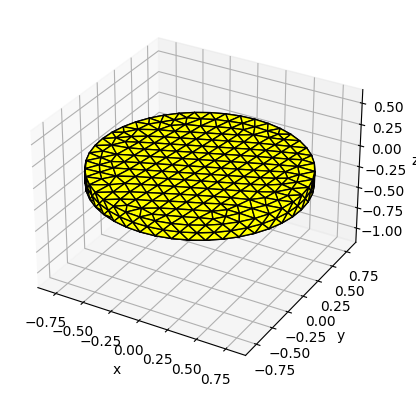

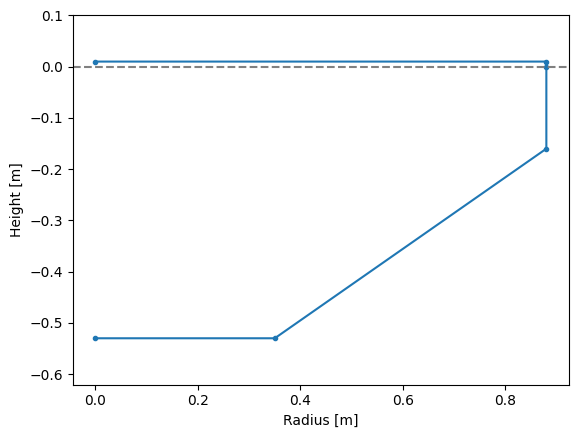

In [4]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True)  # specific to WaveBot

#### BEM
With our Capytaine floating body created, we can now run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object. This is wrapped into the `wecopttool.run_bem` function.

We will analyze 50 frequencies with a spacing of 0.05 Hz. These frequencies will be used for the Fourier representation of both the wave and the desired PTO force in the pseudo-spectral problem. See the Theory section of the Documentation for more details on the pseudo-spectral problem formulation.

If you would like to save our BEM data to a NetCDF file for future use, see the `wecopttool.write_netcdf` function.

In [5]:
f1 = 0.05
nfreq = 50
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

bem_data = wot.run_bem(fb, freq)

#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC. Data wrapped into our `PTO` class will be used to help define our `WEC` object and optimization problem later.

To create an instance of the `PTO` class, we need:
- The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom. The PTO extracts power directly from the WEC's heave in this case, so the kinematics matrix is simply the $1 \times 1$ identity matrix.
- The definition of the PTO controller. The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force. However, we will be using an unstructured controller in this case, so we will set `None` for the controller.
- Any PTO impedance. We're only interested in mechanical power for this first problem, so we will leave this empty for now
- The non-linear power conversion loss (assumed 0% if `None`)
- The PTO system name, if desired

In [6]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now let's define the PTO forcing on the WEC and the PTO constraints. For our optimization problem, the constraints must be in the correct format for `scipy.optimize.minimize()`. We will enforce the constraint at 4 times more points than the dynamics (see Theory for why this is helpful for the pseudo-spectral problem).

In [7]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 2000.0
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

#### `WEC` creation
We are now ready to create the `WEC` object itself! Since we ran our BEM already, we can define the object using the `wecopttool.WEC.from_bem` function. If we saved our BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [8]:
wec = wot.WEC.from_bem(
    bem_data,
    inertia_matrix=mass,
    hydrostatic_stiffness=stiffness,
    constraints=constraints,
    friction=None,
    f_add=f_add,
)

### Waves
The wave environment must be specified as a 2-dimensional `xarray.DataArray` containing the complex amplitude (m). 
The two coordinates are the radial frequency ``omega`` (rad/s)  and the direction ``wave_direction`` (rad). 
The `wecopttool.waves` submodule contains functions for creating this `xarray.DataArray` for different types of wave environments. 

In this case we will use a regular wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m. 
We will use the `wecopttool.waves.regular_wave` function. 

In [9]:
amplitude = 0.0625  
wavefreq = 0.3
phase = 30
wavedir = 0
waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

### Objective function
The objective function is the quantity (scalar) we want to optimize—in this case, the average mechanical power. The objective function is itself a function of the optimization state, the size of which we need to properly define our call to `scipy.optimize.minimize()`. The average mechanical power can be taken directly from the `PTO` object we created:

In [10]:
obj_fun = pto.mechanical_average_power
nstate_opt = 2*nfreq+1

### Solve
We are now ready to solve the problem. WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

Note that the only required inputs for defining and solving the problem are: (1) the waves, (2) the objective function, and (3) the size of the optimization state. Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance. See `scipy.optimize.minimize` docs for more details.

To help the optimization we will scale the problem before solving it (see Documentation). WecOptTool allows you to scale the WEC dynamics state, your optimization state (in this case the Fourier coefficients for the PTO force), and the objective function separately. See the `wecopttool.WEC.solve()` function for more information.

Pay attention to the `Exit mode`: an exit mode of $0$ indicates a successful solution.

In [11]:
options = {'maxiter': 1000}
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results.fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0173564128743378
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46
Optimal average mechanical power: -101.73564128743378 W


### Analyzing results
We will use two post-processing functions to obtain frequency- and time-domain results for the WEC and PTO responses. The pseudospectral method gives continuous in time results. To get smoother looking plots, we specify the number of subpoints betweeen co-location points. In this case we will use 5. 

In [12]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)

The `pto.post_process` function returns `xarray.Dataset`s, which have built-in integration with PyPlot for smart plotting that automagically sets titles and formatting. We will query the `mech_power` variable here since it is our variable of interest, but `pos`, `vel`, `acc`, `force`, and (electrical) `power` are also available.

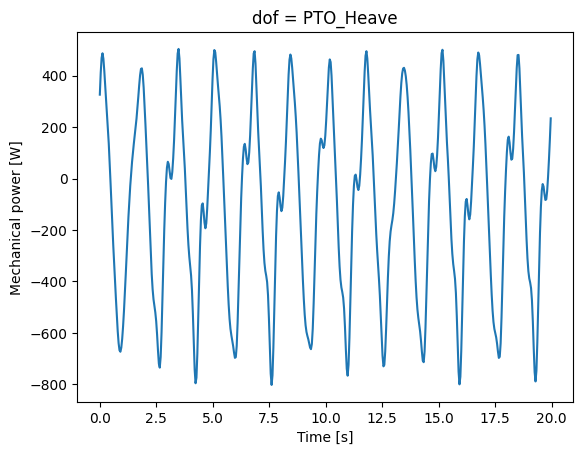

In [13]:
plt.figure()
pto_tdom['mech_power'].plot()

We could similarly plot any time- or frequency-domain repsonse of the WEC or PTO. For instance, here is the PTO heave motion.

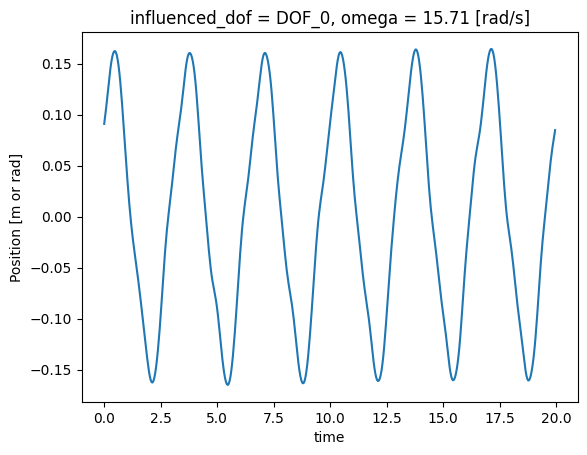

In [14]:
plt.figure()
wec_tdom['pos'].plot()

## 2. Optimal control for maximum electrical power

The rest of this tutorial will focus on optimizing for electrical power rather than mechanical, as this is how WecOptTool is best used.

Since we're still dealing with the same WaveBot as part 1, we can reuse the BEM and wave data from before. Look back at pat 1 if you need a refresher on how to create these data.

First, let's add a definition of the PTO impedance.

In [15]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance_2 = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

Next, we will create a new `PTO` object with this impedance matrix. We will also need to update the definitions of our PTO constraint and additional dynamic forcing function to use the new object. We will set our PTO constraint to $800 N$ for this example.

In [16]:
## Update PTO
name_2 = ['PTO_Heave_Ex2']
pto_2 = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_2, loss, name_2)

## Update PTO constraints and forcing
f_max_2 = 800.0
def const_f_pto_2(wec, x_wec, x_opt, waves):
    f = pto_2.force_on_wec(wec, x_wec, x_opt, nsubsteps)
    return f_max_2 - np.abs(f.flatten())
ineq_cons_2 = {'type': 'ineq', 'fun': const_f_pto_2}
constraints_2 = [ineq_cons_2]
f_add_2 = {'PTO': pto_2.force_on_wec}

Finally, let's update our `WEC` object with a constant dissipation value and the new PTO constraint, then run our optimization problem. Note we're now using `average_power` instead of `mechanical_average_power` as our objective function.

In [17]:
# Update WEC
dissipation = np.array([[160.3]])
wec_2 = wot.WEC.from_bem(bem_data,
                         inertia_matrix=mass,
                         hydrostatic_stiffness=stiffness,
                         constraints=constraints_2,
                         friction=dissipation,
                         f_add=f_add_2
)

# Update objective function
obj_fun_2 = pto_2.average_power

# Solve
scale_x_wec = 1e1  # TODO: change
scale_x_opt = 1e-3  # TODO: change
scale_obj = 1e-2  # TODO: change

results_2 = wec_2.solve(
    waves, 
    obj_fun_2, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results_2.fun
print(f'Optimal average electrical power: {opt_average_power} W')

# Post-process
wec_fdom_2, wec_tdom_2 = wec_2.post_process(results_2, waves, nsubsteps)
pto_fdom_2, pto_tdom_2 = pto_2.post_process(wec_2, results_2, waves, nsubsteps)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.27671910665351407
            Iterations: 13
            Function evaluations: 15
            Gradient evaluations: 13
Optimal average electrical power: -27.671910665351405 W


We will compare our optimal results to the unconstrained case to gain some insight into the effect of the constraint on the optimal PTO force. Let's do the same process as before, but unset the `constraints` parameter in a new `WEC` object.

In [18]:
wec_2_nocon = wot.WEC.from_bem(
    bem_data,
    inertia_matrix=mass,
    hydrostatic_stiffness=stiffness,
    constraints=None,
    friction=dissipation,
    f_add=f_add_2)

results_2_nocon = wec_2_nocon.solve(
    waves, 
    obj_fun_2, 
    nstate_opt, 
)
opt_average_power = results_2_nocon.fun
print(f'Optimal average electrical power: {opt_average_power} W')
wec_fdom_2_nocon, wec_tdom_2_nocon = wec_2_nocon.post_process(
    results_2_nocon, waves, nsubsteps)
pto_fdom_2_nocon, pto_tdom_2_nocon = pto_2.post_process(
    wec_2_nocon, results_2_nocon, waves, nsubsteps)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.135575115822615
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimal average electrical power: -28.135575115822615 W


Note that the optimal constrained PTO force follows the optimal unconstrained solution (sinusoidal) whenever the unconstrained solution is within the constraint. 
When the constraint is active the optimal PTO force is the maximum PTO force of $800 N$.

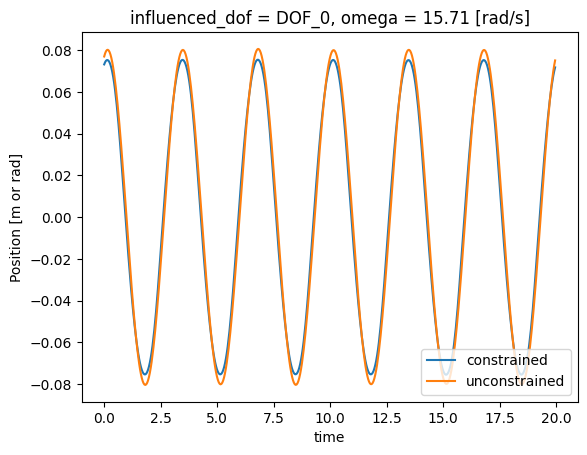

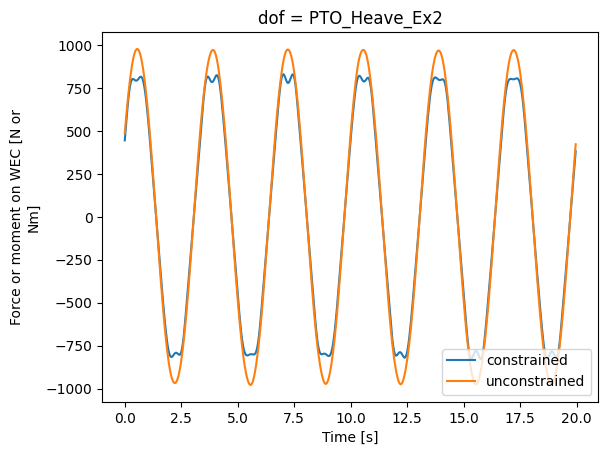

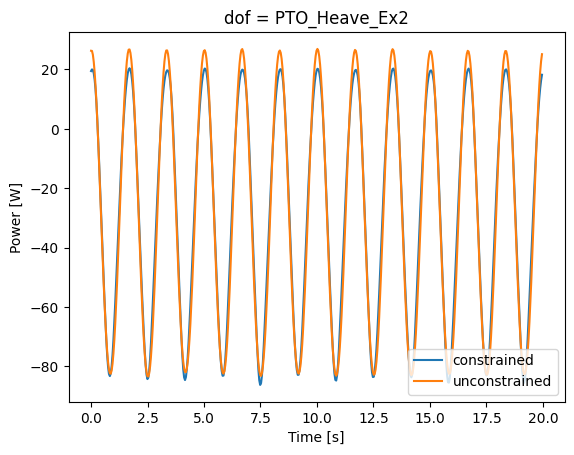

In [19]:
plt.figure()
wec_tdom_2['pos'].plot(label='constrained')
wec_tdom_2_nocon['pos'].plot(label='unconstrained')
plt.legend(loc='lower right')

plt.figure()
pto_tdom_2['force'].plot(label='constrained')
pto_tdom_2_nocon['force'].plot(label='unconstrained')
plt.legend(loc='lower right')

plt.figure()
pto_tdom_2['power'].plot(label='constrained')
pto_tdom_2_nocon['power'].plot(label='unconstrained')
plt.legend(loc='lower right')

## 3. Control co-design of the WEC's geometry for maximum electrical power
The first two examples only used the inner optimization loop in WecOptTool to optimize PTO power. Here in Part 3 we bring it all together and show how to use both the inner and outer optimization loops in WecOptTool to do control co-optimization of a hull design.
Again, we use the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average produced electrical power, while maintaining a constant volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geometry (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in Example 2 and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg)

### Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

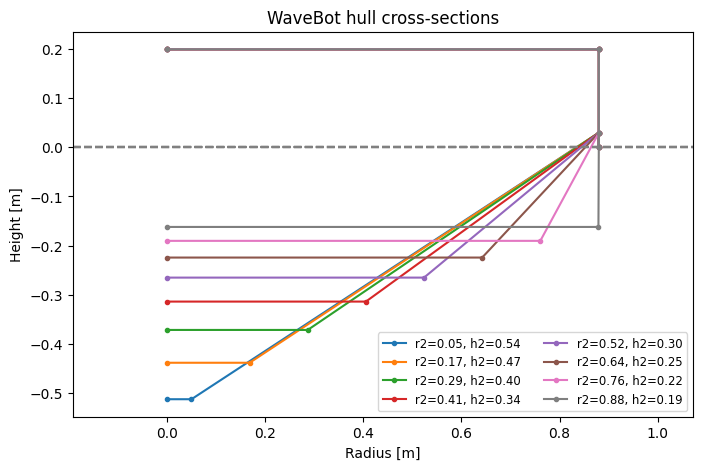

In [20]:
from datetime import datetime
from scipy.optimize import brute

r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))

r2_vals = np.linspace(0.05, 0.88*0.999, 8, endpoint=True)


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


# plot
mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
for r2, h2 in zip(r2_vals.tolist(), h2_vals):
    _ = wot.geom.WaveBot(r2=r2, h2=h2, freeboard=0.2).plot_cross_section(
        ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}")
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')


Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Part 2 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

In [21]:
def design_obj_fun(x):

    # Unpack geometry variables
    r2 = x[0]
    h2 = h2_from_r2(r2)
    print(f"\nr2 = {r2:.2f}:")

    # Set up Capytaine floating body
    wb = wot.geom.WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="Heave")
    ndof = fb.nb_dofs

    # Run BEM
    f1 = 0.05
    nfreq = 50
    bem_data = wot.run_bem(fb, freq)

    # Mass & hydrostatic stiffness
    stiffness = wot.hydrostatics.stiffness_matrix(fb).values
    mass = wot.hydrostatics.inertia_matrix(fb).values

    # Impedance definition
    omega = bem_data.omega.values
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

    # Set PTO object
    name = ["PTO_Heave",]
    kinematics = np.eye(ndof)
    efficiency = None
    controller = None
    pto = wot.pto.PTO(ndof, kinematics, controller, None, efficiency, name)

    # Set PTO constraint and additional dynamic force
    nsubsteps = 4
    f_max = 2000.0

    def const_f_pto(wec, x_wec, x_opt, waves):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq', 'fun': const_f_pto}
    constraints = [ineq_cons]

    f_add = {'PTO': pto.force_on_wec}

    # Create WEC
    wec = wot.WEC.from_bem(bem_data,
            inertia_matrix=mass,
            hydrostatic_stiffness=stiffness,
            constraints=constraints,
            friction=None, #160.3
            f_add=f_add,
            )

    # Waves
    wfreq = 0.6
    amplitude = 0.0625
    phase = -40
    waves = wot.waves.regular_wave(f1, nfreq, wfreq, amplitude, phase)

    # Objective function
    obj_fun = pto.average_power
    ncomponents_pto = 2*nfreq+1

    # Solve
    scale_x_opt = 1  # TODO: add all scales, usea same values as in Part 2
    res = wec.solve(
        waves, obj_fun, ncomponents_pto, scale_x_opt=scale_x_opt)

    return res.fun

### Solve
Finally, we may call this objective function with an optimization algorithm. 
Here, a simple *brute force* optimization approach is used for illustrative purposes, but any variety of options could be applied. 
The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the PTO force that provides the most electric power for that hull. 
This process will be conducted for the range of `r2` values that we specify.

_(note: the cell below will likely take 5+ minutes to run on a standard personal computer)_

In [22]:
# range over which to search
ranges = (slice(r2_vals[0], r2_vals[-1]+np.diff(r2_vals)[0], np.diff(r2_vals)[0]),)

# solve
opt_x0, opt_fval, x0s, fvals = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)


r2 = 0.05:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -17.14096963358091
            Iterations: 8
            Function evaluations: 8
            Gradient evaluations: 8

r2 = 0.17:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -17.088163923900318
            Iterations: 8
            Function evaluations: 8
            Gradient evaluations: 8

r2 = 0.29:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -17.10244596780222
            Iterations: 14
            Function evaluations: 14
            Gradient evaluations: 14

r2 = 0.41:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -17.05055002093832
            Iterations: 8
            Function evaluations: 8
            Gradient evaluations: 8

r2 = 0.52:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -17.01484999765237
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15

r2 = 0.64:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -16.311710515331573
            Iterations: 8
            Function evaluations: 8
            Gradient evaluations: 8

r2 = 0.76:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.307475603954407
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15

r2 = 0.88:


Optimization terminated successfully    (Exit mode 0)
            Current function value: -13.55096934879381
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15


### Results
From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) generally improves for smaller values of `r2`.
It is also clear that when the WEC is cylindrical (where `r2=0.88`), power absorption is reduced.

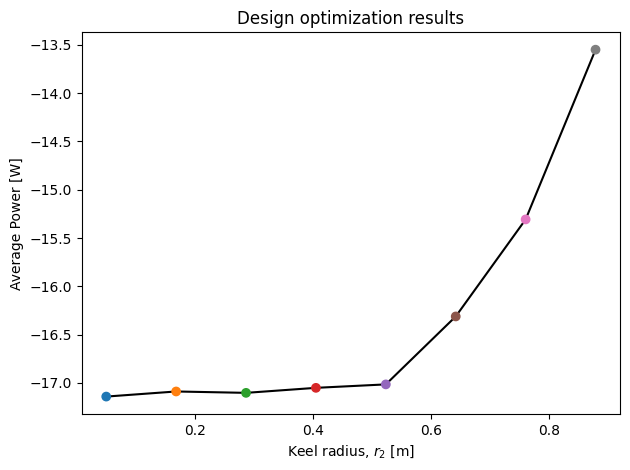

In [23]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(x0s)]
ax.plot(x0s, fvals, 'k', zorder=0)
ax.scatter(x0s, fvals, c=colors, zorder=1)

ax.set_xlabel('Keel radius, $r_2$ [m]')
ax.set_ylabel('Average Power [W]')
ax.set_title('Design optimization results')
fig.tight_layout()